# ДЗ №3 
## Обучение моделей глубокого обучения на PyTorch

Ваша задача на этой неделе - повторить модель трёхслойного перцептрона из прошолго задания на **PyTorch**, разобрать лучшие практики обучения моделей глубокого обучения и провести серию экспериментов

In [2]:
import torch
# from torch import functional as F
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, List, Type, Dict, Any

Для того, чтобы эксперимент можно было повторить, хорошей практикой будет зафиксировать генератор случайных чисел. Также, рекоммендуется зафиксировать RNG в numpy и, если в качестве бэкенда используется cudnn - включить детерминированный режим.

Подробнее: https://pytorch.org/docs/stable/notes/randomness.html

In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Модель

Основным способом организации кода на **Pytorch** является модуль. Простые модели могут быть реализованны из готовых модулей ( к примеру, `torch.nn.Sequential`, `torch.nn.Linear` и т.д. ), для более сложных архитектур часто приходтся реализовывать собственные блоки. Это достаточно легко сделать - достаточно написать класс, наследуемый от `torch.nn.Module` и реализующий метод `.forward`, который принимает и возвращает тензоры ( `torch.Tensor` ). Чаще всего этого достаточно и писать реализацию метода `backward` не нужно: за вас это сделает библиотека автоматического вычисления градиентов, реализованная в **Pytorch**.

Пример реализации кастомного модуля из официальной документации: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Здесь нелишним будет напомнить, что в подходе, используемом в Pytorch, все обучаемые параметры модуля должны существовать как атрибуты экземпляра этого модуля. То есть, объекты, соответствующие исполняемым объектам (`callable`), содержащим обучаемые параметры модуля, должны быть атрибутами этого модуля (`self.xxx`) и должны быть созданы в методе `__init__()`. При этом применяться к данным они должны в методе `forward()` этого модуля.

#### Задание 1

Повторите реализацию трёхслойного перцептрона из предыдущего задания на **Pytorch**. Желательно также, чтобы реализация модели имела параметризуемую глубину ( количество слоёв ), количество параметров на каждом слое и функцию активации. Отсутствие такой возможности не снижает балл, но сильно поможет в освоении принципов построения нейросетей с применением библиотеки pytorch.

In [4]:
class Perceptron(torch.nn.Module):
    def __init__(self,
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1,
                 hidden_layer_features: List[int] = [256],
                 activation: Type[torch.nn.Module] = nn.SELU,
                 num_classes: int = 10):

        super().__init__()
        in_features = input_channels * input_resolution[0] * input_resolution[1]
        self.nn_layers = []
        self.nn_layers.append(nn.Linear(in_features, hidden_layer_features[0]))

        for i in range(len(hidden_layer_features) - 1):
            self.nn_layers.append(activation())
            self.nn_layers.append(
                nn.Linear(hidden_layer_features[i],
                          hidden_layer_features[i + 1]))

        self.nn_layers.append(activation())
        self.nn_layers.append(
            torch.nn.Linear(hidden_layer_features[-1], num_classes))
        self._nn_layers = torch.nn.Sequential(*self.nn_layers)

    def forward(self, x):
        output = self._nn_layers.forward(x)
        return output

Следующий код позволяет посмотреть архитектуру получившейся модели и общее количество обучаемых параметров. Мы хотим, чтобы количество параметров в модели было порядка сотен тысяч. Если у вас получается больше или меньше, попробуйте изменить архитектуру модели.

In [5]:
model = Perceptron(activation=nn.ReLU)
print(model)
print('Total number of trainable parameters',
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (_nn_layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)
Total number of trainable parameters 203530


### Обучающая выборка

На практике, наиболее важным для успеха обучения любой модели машинного обучения является этап подготовки данных. Модели глубокого обучения не являются исключением. Большая, чистая, репрезентативная и релевантная поставленной задаче обучающая выборка часто важнее, чем архитектура самой модели. В предлагаемой задаче используется качественный и проверенный временем MNIST. Однако в практических задачах часто будет получаться так, что лучшим способом добиться улучшения качества модели будет сбор дополнительных данных и очистка исходных данных.

### Предобработка данных

Для улучшения сходимости алгоритма обучения и качества полученной модели данные могут быть предварительно обработаны:

1. Среднее каждой входной переменной близко к нулю
2. Переменные отмасштабированы таким образом, что их дисперсии примерно одинаковы ( из соображений вычислительной устойчивости, мы хотим, чтобы все величины по порядку величины были близки к еденице )
3. По возможности, входные переменные не должны быть скоррелированны. Важнось этого пункта в последние годы ставится под сомнение, но всё-же в некоторых случаях это может влиять на результат

Подробнее можно почитать здесь: http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf

### Аугментация (искусственное дополнение) обучающей выборки

В зависимости от задачи можно применять к признаковому описанию объектов обучающей выборки различные преобразования, которые позволят увеличить эффективный размер выборки без дополнительной разметки. К примеру, для задачи классификации кошек и собак можно зеркально отразить изображение вокруг вертикальной оси - при этом класс изображения не изменится, а само изображение останется по прежнему будет принадлежать исходному распределению. Есть много разных техник аугментации, и их применимость и эффективность сильно зависит от данных и задачи.

Подробнее можно почитать здесь: https://link.springer.com/content/pdf/10.1186/s40537-019-0197-0.pdf

### Задание 2

Обоснуйте, почему аугментация обучающей выборки позволяет добиться прироста качества модели, несмотря на то, что она не добавляет в неё дополнительную информацию.

* В качестве примера рассмотрим обучение из естественных изображений, которое создается на основе реальных данных. Для того, чтобы судить об эффективности модели в реальных условиях, собирать данные необходимо в различных условиях — освещение, разные модели телефонов, камер, с которых происходит съемка, различные источники документов (типографии), и т. д. Все это усложняет сбор необходимого числа примеров для обучения распознавателя. Другой подход к созданию обучающих данных — их искусственная генерация. Такой подход не требует большого количества человеческих ресурсов и сравнительно дешев, поскольку не требует разметки и сбора данных — весь процесс создания базы изображений определяется выбором алгоритма и параметров.

* Обученный только на близких к идеалу изображениях классификатор, не видевший все возможные деформации, с большой долей вероятности будет ошибаться на сильно искаженных изображениях. Аугментация как раз позволяет порождать бесконечное множество условий получения данных, тем самым увеличивая обучающую выборку. Видя постоянно новые данные, сеть не может настраивать лишние фильтры для выцепления специфичных особенностей конкретного набора данных.
* Также аугментация может служить для достижения сбалансированности датасета. К примеру, у нас имеется датасет с изображениями кошечек и собачек, на котором животные находятся в правой части изображения. Модель, обученная на таком датасете, будет плохо работать с изображениями, на которых кошечки и собачки находятся в левой части изображения. Путем симметричного отображения мы получим новые (полученные из старых) признаки, которые позволят построить нам модель более устойчивую к расположению кошечек и собачек.

### Задание 3

Какие осмысленные аугментации вы можете придумать для следующих наборов данных:

1. Набор изображений животных, размеченый на виды животных
2. Набор аудиозаписей голоса, размечеными на языки говорящего
3. Набор cо показаниями датчиков температуры, влажности и давления с одной из метеостанций, размеченый на признак наличия осадков

1. Аугментацией для набора изображений животных может послужить симметричное отражение картинок, масштабирование, обрезание, изменение цвета, искажение изображения. Так как признаками являются пиксели, то сеть, видя постоянно новые признаки, не сможет обучаться на "конкретных" данных и будет более устойчива к расположению животных на картинках, их масштабу, цвету и сможет работать с изображениями, на которых есть искажения.
2. Намеренное искажение звука (запись голоса в метро, толпе людей, невнятная речь и т.д), ускорение и замедление голоса. Таким образом, модель обучаясь на таких данных, не будет зависеть от конкретной скорости голоса и сможет распозновать голоса с искаженным звуком (Например, ВКонтакте, делая распознование голосовых сообщений, просили десятки тысяч выбранных пользователей, записывать аудиосообщения в самых разных местах от людей с самым разным "говором".  Это делалось для того, чтобы расширить умения распознования нейросети на более широкий круг людей и мест их обитания, так как наши обычные условия, в которых мы записываем голосовые сообщения, далеки от идеальных). Это не пример аугментации, но пример того, почему "неидеальные условия" так важны. 
3. Добавить шум в данные. Добавление шума во время обучения модели нейронной сети оказывает эффект регуляризации и, в свою очередь, повышает надежность модели. Было показано, что оно оказывает такое же влияние на функцию потерь, как и добавление штрафного члена, как в случае методов регуляризации веса.

### Задание 4

Напишите пайплайн для предобработки и аугументации данных. В `torchvision.transforms` есть готовые реализации большинства распространённых техник. Если вы хотите добавить что-то своё, вы можете воспользоваться `torchvision.transforms.Lambda`. При этом следует понимать, что если нужно оценить качество модели на оригинальных данных, пайплайн предварительной обработки данных валидационной выборки не должен включать аугментаций. Следует помнить, однако, что существует подход аугментации данных в момент применения модели (test-time augmentation), который позволяет повысить качество модели в режиме исполнения.

Одним из обязательных шагов в вашем пайплайне должна быть конвертация данных в тензоры Pytorch (`torch.Tensor`): `torchvision.transforms.ToTensor()`.

In [6]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #Эти числа - среднее и стандартное отклонение набора данных MNIST .
    torchvision.transforms.Normalize((0.1307, ), (0.3081, )),
    torchvision.transforms.RandomResizedCrop(size=(28, 28),
                                             scale=(.5, 1.0),
                                             ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=30)
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307, ), (0.3081, ))
])

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./mnist',
                                           train=True,
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist',
                                         train=False,
                                         download=True,
                                         transform=val_transforms)

Перед тем как запускать обучение всегда стоит посмотреть на данные после предобработки, и удостовериться, что они соответствуют ожидаемым

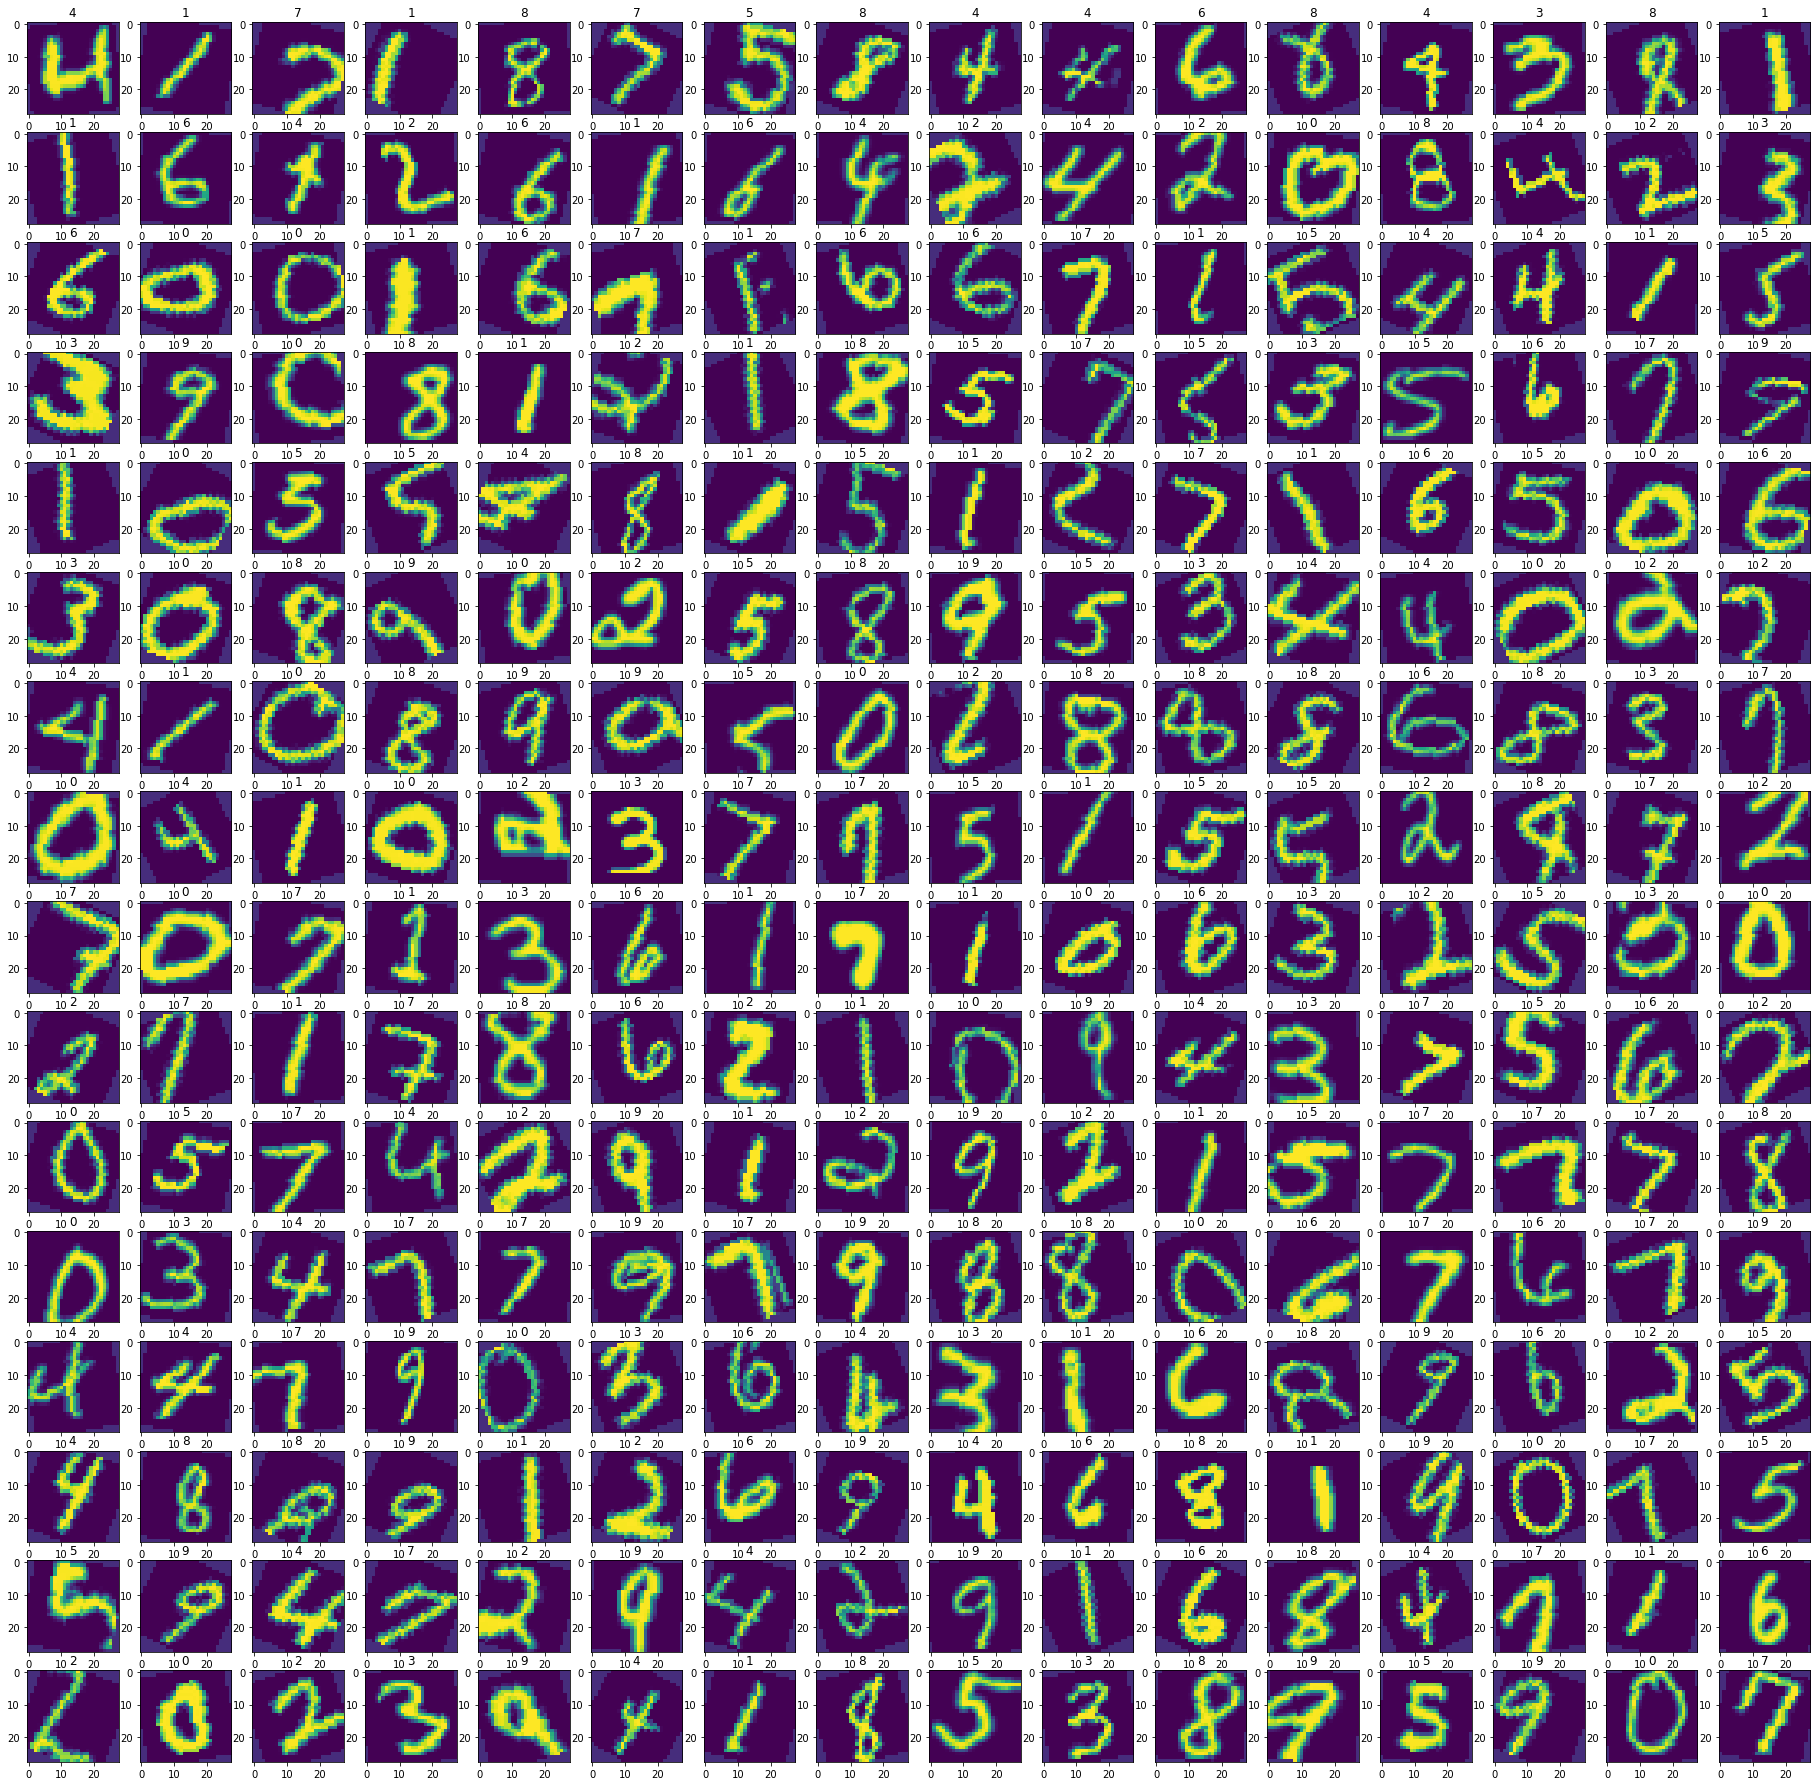

In [8]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=16, ncols=16, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i * 16 + j]
        sample, label = train_dataset[sample_index]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0))
        ax.set_title(label)

### Обучение модели

Теперь, когда мы реализовали модель и подготовили данные мы можем приступить к непосредственному обучению модели. Костяк функции обучения написан ниже, далее вы должны будете реализовать ключевые части этого алгоритма

In [9]:
def train_model(
        model: torch.nn.Module,
        train_dataset: torch.utils.data.Dataset,
        val_dataset: torch.utils.data.Dataset,
        loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
        optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
        optimizer_params: Dict = {},
        initial_lr=0.01,
        lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_params: Dict = {},
        batch_size=128,
        max_epochs=1000,
        early_stopping_patience=20):
    optimizer = optimizer_class(model.parameters(),
                                 lr=initial_lr,
                                 **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               shuffle=True,
                                               batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size)

    best_val_loss = None
    best_epoch = None

    for epoch in range(max_epochs):

        print(f'Epoch {epoch}')
        train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])

        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')

        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

### Задание 5

Реализуйте функцию, производящую обучение сети на протяжении одной эпохи ( полного прохода по всей обучающей выборке ). На вход будет приходить модель, оптимизатор, функция потерь и объект типа `DataLoader`. При итерировании по `data_loader` вы будете получать пары вида ( данные, целевая_переменная )

In [10]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer,
                       loss_function: torch.nn.Module,
                       data_loader: torch.utils.data.DataLoader):
    model.train()
    for x_batch, y_batch in data_loader:
        optimizer.zero_grad()
        x_batch = x_batch.view(-1, 784)
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()

### Задание 6

Реализуйте функцию производящую вычисление функции потерь на валидационной выборке.  На вход будет приходить модель, функция потерь и `DataLoader`. На выходе ожидается словарь с вида:
```
{
    'loss': <среднее значение функции потерь>,
    'accuracy': <среднее значение точности модели>
}
```

In [11]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module,
                          data_loader: torch.utils.data.DataLoader):
    model.eval()
    loss_history = []
    accuracy_history = []
    acc = 0
    batches = 0
    loss = 0
    for x_batch, y_batch in data_loader:
        batches += 1
        x_batch = x_batch.view(-1, 784)
        with torch.no_grad():
            y_pred = model(x_batch)
        loss += loss_function(y_pred, y_batch).item()
        acc += (torch.argmax(y_pred, dim=1) == y_batch).cpu().numpy().mean()

    return {'loss': loss / len(data_loader.dataset), 'accuracy': acc / batches}

Если вы корректно реализовали все предыдущие шаги и ваша модель имеет достаточное количество обучаемых параметров, то в следующей ячейке должен пойти процесс обучения, и мы должны достичь итоговой точности (в смысле меры accuracy, доли верных ответов) выше 90%

In [12]:
# Убедимся, что наша модель работает. 
# Для этого воссоздадим перцептрон с одним скрытым слоем из прошлой домашки, правда, с другим оптимизатором.
train_model(model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            loss_function=torch.nn.functional.cross_entropy,
            optimizer_class=torch.optim.SGD,
            initial_lr=0.01,
            max_epochs=100)

Epoch 0
Validation metrics: 
{'loss': 0.006904238638281822, 'accuracy': 0.7792721518987342}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.005355511501431465, 'accuracy': 0.8432555379746836}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.00442725330889225, 'accuracy': 0.8714398734177216}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.003703617450594902, 'accuracy': 0.8941851265822784}
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.0032241252586245536, 'accuracy': 0.9098101265822784}
Best model yet, saving
Epoch 5
Validation metrics: 
{'loss': 0.002862913356721401, 'accuracy': 0.9178204113924051}
Best model yet, saving
Epoch 6
Validation metrics: 
{'loss': 0.002603440372645855, 'accuracy': 0.9269185126582279}
Best model yet, saving
Epoch 7
Validation metrics: 
{'loss': 0.002415053492039442, 'accuracy': 0.9297863924050633}
Best model yet, saving
Epoch 8
Validation metrics: 
{'loss': 0.0022173604264855385, 'accuracy': 0.93680

Validation metrics: 
{'loss': 0.0007057069283910095, 'accuracy': 0.9774525316455697}
Best model yet, saving
Epoch 77
Validation metrics: 
{'loss': 0.0006982051148079336, 'accuracy': 0.9767602848101266}
Best model yet, saving
Epoch 78
Validation metrics: 
{'loss': 0.0006986427784897387, 'accuracy': 0.9779469936708861}
Epoch 79
Validation metrics: 
{'loss': 0.0007156547375489026, 'accuracy': 0.9763647151898734}
Epoch 80
Validation metrics: 
{'loss': 0.0007024303467944265, 'accuracy': 0.9759691455696202}
Epoch 81
Validation metrics: 
{'loss': 0.0006813303662929684, 'accuracy': 0.9771558544303798}
Best model yet, saving
Epoch 82
Validation metrics: 
{'loss': 0.0007100090698339046, 'accuracy': 0.9761669303797469}
Epoch 83
Validation metrics: 
{'loss': 0.000685544806253165, 'accuracy': 0.9767602848101266}
Epoch 84
Validation metrics: 
{'loss': 0.000688131268741563, 'accuracy': 0.9771558544303798}
Epoch 85
Validation metrics: 
{'loss': 0.0006923842754680663, 'accuracy': 0.9759691455696202}
Ep

Как мы видим accuracy на лучшей модели получился ~0.978 и он примерно такой же, как и accuracy, полученный на лучшей модели в предыдущем Д/З.

### Задание 7

Модифицируйте процесс обучения таким образом, чтобы достигнуть наилучшего качества на валидационной выборке. Модель должна оставаться N-слойным перцептроном с количеством обучаемых параметров <= 500000. Для обучения разрешается использовать только набор данных MNIST. Процесс обучения вы можете изменять по собственному усмотрению. К примеру, вы можете менять:

* Архитектуру модели в рамках наложенных ограничений на количество параметров и вид архитектуры (многослойный перцептрон)
* Функции активации в модели
* Используемый оптимизатор
* Расписание шага оптимизации
* Сэмплинг данных при обучении ( e.g. hard negative mining)

В результате мы ожидаем увидеть код экспериментов и любые инсайты, которые вы сможете получить в процессе

Модифицируем процесс обучения таким образом, чтобы достигнуть наилучшего качества на валидационной выборке. Для начала сделаем из нашей модели перцептрон с тремя скрытыми слоями и поменяем оптимайзер на "Adagrad".

In [13]:
model = Perceptron(hidden_layer_features=[256, 128, 64], activation=torch.nn.ReLU)
train_model(model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            loss_function=nn.functional.cross_entropy,
            optimizer_class=torch.optim.Adagrad,
            initial_lr=0.01,
            max_epochs=100)


Epoch 0
Validation metrics: 
{'loss': 0.00154261077567935, 'accuracy': 0.9389833860759493}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.0012156604507938028, 'accuracy': 0.9495648734177216}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.0009804806815460324, 'accuracy': 0.9613330696202531}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.0008265312536153942, 'accuracy': 0.9678599683544303}
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.0008050147796515375, 'accuracy': 0.9685522151898734}
Best model yet, saving
Epoch 5
Validation metrics: 
{'loss': 0.0006983090246561915, 'accuracy': 0.9724090189873418}
Best model yet, saving
Epoch 6
Validation metrics: 
{'loss': 0.0007603096608072519, 'accuracy': 0.9719145569620253}
Epoch 7
Validation metrics: 
{'loss': 0.0006768967903219164, 'accuracy': 0.9739912974683544}
Best model yet, saving
Epoch 8
Validation metrics: 
{'loss': 0.0006526025144616142, 'accuracy': 0.9740901898734177}
Best

Validation metrics: 
{'loss': 0.00034559942562773356, 'accuracy': 0.9851661392405063}
Epoch 81
Validation metrics: 
{'loss': 0.0003440958419814706, 'accuracy': 0.9855617088607594}
Epoch 82
Validation metrics: 
{'loss': 0.00034901977557165085, 'accuracy': 0.9855617088607594}
Epoch 83
Validation metrics: 
{'loss': 0.00036882564730476587, 'accuracy': 0.9851661392405063}
Epoch 84
Validation metrics: 
{'loss': 0.0003526510937605053, 'accuracy': 0.986056170886076}
Epoch 85
Validation metrics: 
{'loss': 0.0003319912570499582, 'accuracy': 0.9871439873417721}
Epoch 86
Validation metrics: 
{'loss': 0.000338385838503018, 'accuracy': 0.9861550632911392}
Epoch 87
Validation metrics: 
{'loss': 0.000336913137108786, 'accuracy': 0.9863528481012658}
Epoch 88
Validation metrics: 
{'loss': 0.00036342304876889103, 'accuracy': 0.9847705696202531}
Epoch 89
Validation metrics: 
{'loss': 0.00033628448802046476, 'accuracy': 0.9870450949367089}
Epoch 90
Validation metrics: 
{'loss': 0.0003411099868651945, 'accu

Модель показывает accuracy ~0.9867, но можно попытаться выбить побольше. Поменяем функцию активации на SELU, остальные параметры оставим такими же

In [14]:
model = Perceptron(hidden_layer_features=[256, 128, 64])
train_model(model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            loss_function=nn.functional.cross_entropy,
            optimizer_class=torch.optim.Adagrad,
            initial_lr=0.01,
            max_epochs=100)

Epoch 0
Validation metrics: 
{'loss': 0.0016720516350120305, 'accuracy': 0.9402689873417721}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.001316654109209776, 'accuracy': 0.948378164556962}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.0010654939769767224, 'accuracy': 0.9599485759493671}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.001000332858040929, 'accuracy': 0.9615308544303798}
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.0008227400771342218, 'accuracy': 0.9685522151898734}
Best model yet, saving
Epoch 5
Validation metrics: 
{'loss': 0.0008534317009616643, 'accuracy': 0.9660799050632911}
Epoch 6
Validation metrics: 
{'loss': 0.0008028540276922286, 'accuracy': 0.9697389240506329}
Best model yet, saving
Epoch 7
Validation metrics: 
{'loss': 0.0007216975970659405, 'accuracy': 0.9701344936708861}
Best model yet, saving
Epoch 8
Validation metrics: 
{'loss': 0.0007164569847285748, 'accuracy': 0.9728045886075949}
Best 

Validation metrics: 
{'loss': 0.00040228870471473784, 'accuracy': 0.9835838607594937}
Epoch 80
Validation metrics: 
{'loss': 0.00040089824780006894, 'accuracy': 0.9842761075949367}
Epoch 81
Validation metrics: 
{'loss': 0.00042512198225595055, 'accuracy': 0.9827927215189873}
Epoch 82
Validation metrics: 
{'loss': 0.00039553409919608387, 'accuracy': 0.9832871835443038}
Epoch 83
Validation metrics: 
{'loss': 0.00037882457207888366, 'accuracy': 0.9854628164556962}
Epoch 84
Validation metrics: 
{'loss': 0.00036308747935690915, 'accuracy': 0.9844738924050633}
Epoch 85
Validation metrics: 
{'loss': 0.0003699207071738783, 'accuracy': 0.9847705696202531}
Epoch 86
Validation metrics: 
{'loss': 0.0003632843377883546, 'accuracy': 0.9854628164556962}
Epoch 87
Validation metrics: 
{'loss': 0.0003638944244768936, 'accuracy': 0.9848694620253164}
Epoch 88
Validation metrics: 
{'loss': 0.00036152505771024155, 'accuracy': 0.9846716772151899}
Epoch 89
Validation metrics: 
{'loss': 0.00037228913516155446,

Accuracy упал до ~0.9858. Но ничего, экспериментируем дальше! Попробуем поменять функцию активации и оптимизатор на GELU и Adam соотвественно

In [17]:
model = Perceptron(hidden_layer_features=[256, 128, 64], activation=nn.GELU)
train_model(model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            loss_function=nn.functional.cross_entropy,
            optimizer_class=torch.optim.Adam,
            initial_lr=0.01,
            max_epochs=100)

Epoch 0
Validation metrics: 
{'loss': 0.002084865927696228, 'accuracy': 0.920193829113924}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.0018718975849449635, 'accuracy': 0.9279074367088608}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.0014039864206686617, 'accuracy': 0.9491693037974683}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.001794263307005167, 'accuracy': 0.9345332278481012}
Epoch 4
Validation metrics: 
{'loss': 0.0016105028361082076, 'accuracy': 0.9399723101265823}
Epoch 5
Validation metrics: 
{'loss': 0.0012061605108901858, 'accuracy': 0.958564082278481}
Best model yet, saving
Epoch 6
Validation metrics: 
{'loss': 0.0015437102120369672, 'accuracy': 0.9475870253164557}
Epoch 7
Validation metrics: 
{'loss': 0.0013172831537202, 'accuracy': 0.955498417721519}
Epoch 8
Validation metrics: 
{'loss': 0.0013182642404921353, 'accuracy': 0.9555973101265823}
Epoch 9
Validation metrics: 
{'loss': 0.0011763478553853928, 'accuracy': 0.9588

Validation metrics: 
{'loss': 0.0004638661947043147, 'accuracy': 0.981309335443038}
Epoch 81
Validation metrics: 
{'loss': 0.00044771218907553703, 'accuracy': 0.9819026898734177}
Epoch 82
Validation metrics: 
{'loss': 0.0004473547449626494, 'accuracy': 0.982001582278481}
Epoch 83
Validation metrics: 
{'loss': 0.00041277320365188644, 'accuracy': 0.9831882911392406}
Best model yet, saving
Epoch 84
Validation metrics: 
{'loss': 0.0004072038374200929, 'accuracy': 0.9838805379746836}
Best model yet, saving
Epoch 85
Validation metrics: 
{'loss': 0.00040742796808481216, 'accuracy': 0.9833860759493671}
Epoch 86
Validation metrics: 
{'loss': 0.0004167544971278403, 'accuracy': 0.9829905063291139}
Epoch 87
Validation metrics: 
{'loss': 0.00040989392070914617, 'accuracy': 0.9834849683544303}
Epoch 88
Validation metrics: 
{'loss': 0.00041342685883282685, 'accuracy': 0.9833860759493671}
Epoch 89
Validation metrics: 
{'loss': 0.00041344201766187324, 'accuracy': 0.9837816455696202}
Epoch 90
Validation

Как видим accuracy упал еще больше до ~0.9838. Попробуем вернуть SELU, оптимайзер оставляем таким же, меняем lr на 0.001

In [19]:
model = Perceptron(hidden_layer_features=[256, 128, 64], activation=nn.SELU)
train_model(model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            loss_function=nn.functional.cross_entropy,
            optimizer_class=torch.optim.Adam,
            initial_lr=0.001,
            max_epochs=100)

Epoch 0
Validation metrics: 
{'loss': 0.0019639049042016266, 'accuracy': 0.9229628164556962}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.0015518693957477809, 'accuracy': 0.9363132911392406}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.0012041433330625296, 'accuracy': 0.9479825949367089}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.0008726270872168243, 'accuracy': 0.9669699367088608}
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.0008791086711920798, 'accuracy': 0.9639042721518988}
Epoch 5
Validation metrics: 
{'loss': 0.0009033981880173087, 'accuracy': 0.964003164556962}
Epoch 6
Validation metrics: 
{'loss': 0.0007759420427959412, 'accuracy': 0.9675632911392406}
Best model yet, saving
Epoch 7
Validation metrics: 
{'loss': 0.0007965875258669257, 'accuracy': 0.9677610759493671}
Epoch 8
Validation metrics: 
{'loss': 0.0005459198422031477, 'accuracy': 0.9770569620253164}
Best model yet, saving
Epoch 9
Validation metrics

Validation metrics: 
{'loss': 0.0003003561880730558, 'accuracy': 0.9869462025316456}
Best model yet, saving
Epoch 84
Validation metrics: 
{'loss': 0.0002986683675830136, 'accuracy': 0.9877373417721519}
Best model yet, saving
Epoch 85
Validation metrics: 
{'loss': 0.0003357538702257443, 'accuracy': 0.9870450949367089}
Epoch 86
Validation metrics: 
{'loss': 0.00035815705388085915, 'accuracy': 0.9847705696202531}
Epoch 87
Validation metrics: 
{'loss': 0.00029469375762855636, 'accuracy': 0.9884295886075949}
Best model yet, saving
Epoch 88
Validation metrics: 
{'loss': 0.0003646125510334969, 'accuracy': 0.9853639240506329}
Epoch 89
Validation metrics: 
{'loss': 0.00035303266362461726, 'accuracy': 0.9846716772151899}
Epoch 90
Validation metrics: 
{'loss': 0.0002795587473112391, 'accuracy': 0.9887262658227848}
Best model yet, saving
Epoch 91
Validation metrics: 
{'loss': 0.00034974544775905086, 'accuracy': 0.985067246835443}
Epoch 92
Validation metrics: 
{'loss': 0.0003210732089821249, 'accur

Accuracy на лучшей модели получился ~0.9887, я считаю это очень хорошим показателем. Напоследок попробуем поменять оптимайзер на RMSprop.

In [18]:
model = Perceptron(hidden_layer_features=[256, 128, 64], activation=nn.SELU)
train_model(model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            loss_function=nn.functional.cross_entropy,
            optimizer_class=torch.optim.RMSprop,
            initial_lr=0.01,
            max_epochs=100)

Epoch 0
Validation metrics: 
{'loss': 0.004037229824066162, 'accuracy': 0.8327729430379747}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.0034716737501323224, 'accuracy': 0.8604628164556962}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.002659249226003885, 'accuracy': 0.9118868670886076}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.001746874569915235, 'accuracy': 0.9386867088607594}
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.0024768916711211206, 'accuracy': 0.905557753164557}
Epoch 5
Validation metrics: 
{'loss': 0.00144020059206523, 'accuracy': 0.9499604430379747}
Best model yet, saving
Epoch 6
Validation metrics: 
{'loss': 0.001803977761324495, 'accuracy': 0.940565664556962}
Epoch 7
Validation metrics: 
{'loss': 0.0021237874370999632, 'accuracy': 0.9285007911392406}
Epoch 8
Validation metrics: 
{'loss': 0.0014508473442401736, 'accuracy': 0.9485759493670886}
Epoch 9
Validation metrics: 
{'loss': 0.0015045072626788

Validation metrics: 
{'loss': 0.0005101446072570979, 'accuracy': 0.9810126582278481}
Epoch 82
Validation metrics: 
{'loss': 0.0004901852641138249, 'accuracy': 0.9822982594936709}
Epoch 83
Validation metrics: 
{'loss': 0.0004916293310350739, 'accuracy': 0.9825949367088608}
Epoch 84
Validation metrics: 
{'loss': 0.00050140040415572, 'accuracy': 0.982001582278481}
Epoch 85
Validation metrics: 
{'loss': 0.0004992211013217457, 'accuracy': 0.9818037974683544}
Epoch 86
Validation metrics: 
{'loss': 0.000489285193674732, 'accuracy': 0.982001582278481}
Best model yet, saving
Epoch 87
Validation metrics: 
{'loss': 0.0004849797725095414, 'accuracy': 0.9821004746835443}
Best model yet, saving
Epoch 88
Validation metrics: 
{'loss': 0.0004930352192022838, 'accuracy': 0.9822982594936709}
Epoch 89
Validation metrics: 
{'loss': 0.0005058732661535032, 'accuracy': 0.9817049050632911}
Epoch 90
Validation metrics: 
{'loss': 0.0004945858365856111, 'accuracy': 0.9823971518987342}
Epoch 91
Validation metrics:

К сожалению, accuracy опять упал. Итог, лучший accuracy получился ~0.9887 на модели со следующими параметрами:
* Функция активации: SELU
* Оптимайзер: Adam
* Learning rate: 0.001

Мы рассмотрели 5 моделей с разными параметрами, на всех моделях получился accuracy 0.98+. У меня получилось достигать и accuracy в районе ~0.99, но, к сожалению, результат не сохранился. Так что можно долго играться с параметрами, но accuracy так и будет в районе 0.98-0.99 при адекватных параметрах модели.